In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls "/content/gdrive/MyDrive/Project/data/"

'Emotion Dataset For NLP'/      'Emotions In Texts'/
'Emotion Detection from text'/   prepared_data.csv


In [ ]:
pip install scikit-plot


In [ ]:
pip install nltk

In [ ]:
#Here we import necessary libraries.
import nltk
import numpy as np
import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import scikitplot
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Load the training,validation and test data.
training_data = pd.read_csv("/content/gdrive/MyDrive/Project/data/Emotion Dataset For NLP/train.csv")
validation_data = pd.read_csv("/content/gdrive/MyDrive/Project/data/Emotion Dataset For NLP/val.csv")
test_data = pd.read_csv("/content/gdrive/MyDrive/Project/data/Emotion Dataset For NLP/test.csv")



In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#data preprocessing
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

sid = SentimentIntensityAnalyzer()
wordnet_lemmatizer = WordNetLemmatizer()

def clean_text(text: str):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)
    text = re.sub(r"#", "", text)
    cleaned_text = re.sub(r"https?:\/\/\S+", "", text)
    return cleaned_text

def get_sentiment(text):
    compound = sid.polarity_scores(text).get("compound")
    if -0.2 <= compound <= 0.2:
        sentiment = "Neutral"
    elif -0.5 <= compound < -0.2:
        sentiment = "Negatif"
    elif -1 <= compound < -0.5:
        sentiment = "Very Negatif"
    elif 0.2 < compound <= 0.5:
        sentiment = "Positive"
    elif 0.5 < compound <= 1:
        sentiment = "Very Positive"
    return sentiment

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
Text = "Today is a great day, https://picture.com #joy #happiness"
print(clean_text(Text))

Today is a great day,  joy happiness


In [ ]:
#apply text cleaning function on data sets.
training_data["Cleaned Text"] = training_data.apply(lambda row: clean_text(row["Text"]), axis=1)
training_data["sentiment"] = training_data.apply(lambda row: get_sentiment(row["Cleaned Text"]), axis=1)
validation_data["Cleaned Text"] = validation_data.apply(lambda row: clean_text(row["Text"]), axis=1)
validation_data["sentiment"] = validation_data.apply(lambda row: get_sentiment(row["Cleaned Text"]), axis=1)
test_data["Cleaned Text"] = test_data.apply(lambda row: clean_text(row["Text"]), axis=1)
test_data["sentiment"] = test_data.apply(lambda row: get_sentiment(row["Cleaned Text"]), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


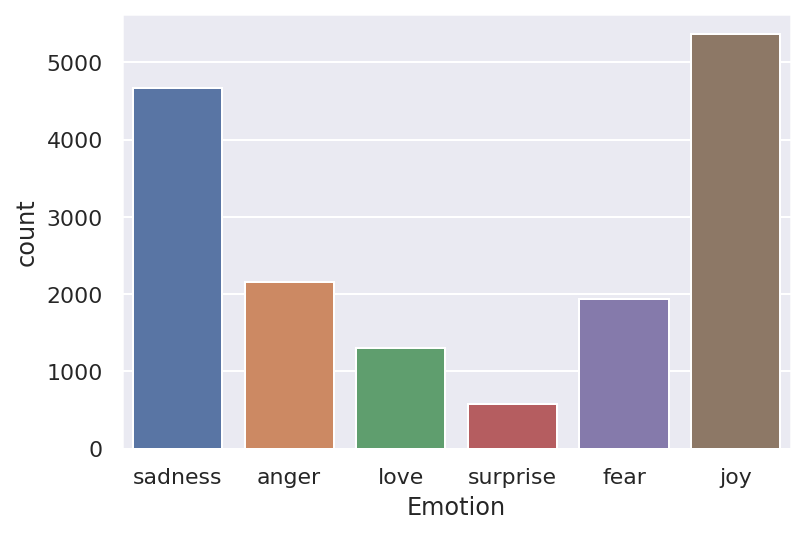

In [ ]:
# just visualization of label distrubution of data sets.
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'
sns.countplot(training_data.Emotion)
plt.show()

In [ ]:
# data validation/elimination
# In order to get rid of incorrect labels, we compare the emotions of the
# labels in the data set with the sentiment analysis we conducted
# using nltk.vader. For example sentiments for 'joy' and 'love' should be either
# very possitive or positive.
training_data["sentiment"] = training_data.apply(lambda row: get_sentiment(row["Cleaned Text"]), axis=1)
training_data = training_data[
    (
        training_data["Emotion"].isin(["joy", "love"])
        & training_data["sentiment"].isin(["Very Positive", "Positive"])
    )
    | (
        training_data["Emotion"].isin(["sadness", "anger","fear"])
        & training_data["sentiment"].isin(["Very Negatif", "Negatif"])
    )
    | (training_data["Emotion"].isin(["surprise"]))
]

validation_data = validation_data[
    (
        validation_data["Emotion"].isin(["joy", "love"])
        & validation_data["sentiment"].isin(["Very Positive", "Positive"])
    )
    | (
        validation_data["Emotion"].isin(["sadness", "anger","fear"])
        & validation_data["sentiment"].isin(["Very Negatif", "Negatif"])
    )
    | (validation_data["Emotion"].isin(["surprise"]))
]

test_data = test_data[
    (
        test_data["Emotion"].isin(["joy", "love"])
        & test_data["sentiment"].isin(["Very Positive", "Positive"])
    )
    | (
        test_data["Emotion"].isin(["sadness", "anger","fear"])
        & test_data["sentiment"].isin(["Very Negatif", "Negatif"])
    )
    | (test_data["Emotion"].isin(["surprise"]))
]



In [ ]:
#checking the shapes after data elimination
print(training_data.shape)
print(validation_data.shape)
print(test_data.shape)

(11468, 4)
(1434, 4)
(1436, 4)


In [ ]:
# Just a helper function to make some investigations just like miss labeled data
def check_kw(text,keyword):
  if keyword in text:
    return True
  else:
    return False
surprise = training_data[training_data.Emotion=="surprise"]
surprise["love"] = surprise.apply(lambda row: check_kw(row["Cleaned Text"],"love"), axis=1)
surprise = surprise[surprise["love"]==True]
surprise["Cleaned Text"].iloc[9]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


'i feel like falling in love with her is part of being amazed at how she makes our family so much better she tells the advocate'

In [ ]:
# Checking label distrubutions
training_data.Emotion.value_counts()
#validation_data.Emotion.value_counts()
#test_data.Emotion.value_counts()

joy         4556
sadness     2969
anger       1369
fear        1032
love         970
surprise     572
Name: Emotion, dtype: int64

In [ ]:
training_data["Cleaned Text"]

2         im grabbing a minute to post i feel greedy wrong
4                                     i am feeling grouchy
5        ive been feeling a little burdened lately wasn...
6        ive been taking or milligrams or times recomme...
7        i feel as confused about life as a teenager or...
                               ...                        
15993    i most days feel like if braeden and calvin ar...
15994        i feel so sympathetic empathetic towards them
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15999    i know a lot but i feel so stupid because i ca...
Name: Cleaned Text, Length: 11468, dtype: object

In [ ]:
# Tokenization
tokenizer=Tokenizer(num_words=13000,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(training_data["Cleaned Text"])

In [ ]:
#Checking the vocabulary size of our data set
max(tokenizer.word_index.values())

12709

In [ ]:
# Converting training text data into the vectors and add padding
X_train=tokenizer.texts_to_sequences(training_data["Cleaned Text"])
X_train=pad_sequences(X_train,maxlen=66,padding='post')






In [ ]:
print(X_train[0])

[  18 3270    7 1264    5  304    2    3  541  434    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(training_data["Cleaned Text"].iloc[0])

im grabbing a minute to post i feel greedy wrong


In [ ]:
# one-hat encoding the training data labels
Y_train= training_data["Emotion"].replace({'joy':0,'sadness':1,
'anger':2,'fear':3,
'love':4,'surprise':5})
Y_train=to_categorical(Y_train)
print(Y_train[0])

[0. 0. 1. 0. 0. 0.]


In [ ]:
Y_train

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_validation=validation_data['Cleaned Text'].astype(str)
Y_validation=validation_data["Emotion"].replace({'joy':0,'sadness':1,
'anger':2,'fear':3,
'love':4,'surprise':5})

In [ ]:
# Converting validation text data into the vectors and addpadding
X_validation=tokenizer.texts_to_sequences(X_validation)
X_validation=pad_sequences(X_validation,maxlen=66,padding='post')

In [ ]:
# another helper function to find number of words in longest sentences.
# before runing this comment the paddings otherwise all the results will be 66(padding length)
X_validation_length_list = []
X_train_length_list = []
for i in X_validation:
  X_validation_length_list.append(len(i))
print(max(X_validation_length_list))
for i in X_train:
  X_train_length_list.append(len(i))
print(max(X_train_length_list))
print(min(X_train_length_list))


66
66
66


In [ ]:
# one-hat encoding for validation data labels
Y_validation=to_categorical(Y_validation)

In [ ]:
Y_validation[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Creating the model
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional
from keras.layers import Dense,Embedding,Dropout
model=Sequential()
embedding_layer = Embedding(12710,64,input_length=66)
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(6,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 66, 64)            813440    
_________________________________________________________________
dropout (Dropout)            (None, 66, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 66, 128)           66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 979,078
Trainable params: 979,078
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Defining the hyperparameters and compiling the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Train the model
train=model.fit(X_train,Y_train,epochs=15,validation_data=(X_validation,Y_validation))

Epoch 1/15
359/359 [==============================] - 36s 27ms/step - loss: 1.4700 - accuracy: 0.4318 - val_loss: 0.9583 - val_accuracy: 0.6297
Epoch 2/15
359/359 [==============================] - 8s 21ms/step - loss: 0.8505 - accuracy: 0.6640 - val_loss: 0.4688 - val_accuracy: 0.8452
Epoch 3/15
359/359 [==============================] - 8s 21ms/step - loss: 0.3761 - accuracy: 0.8739 - val_loss: 0.3058 - val_accuracy: 0.8968
Epoch 4/15
359/359 [==============================] - 8s 21ms/step - loss: 0.2138 - accuracy: 0.9293 - val_loss: 0.2508 - val_accuracy: 0.9184
Epoch 5/15
359/359 [==============================] - 8s 21ms/step - loss: 0.1518 - accuracy: 0.9494 - val_loss: 0.2526 - val_accuracy: 0.9156
Epoch 6/15
359/359 [==============================] - 8s 21ms/step - loss: 0.1139 - accuracy: 0.9636 - val_loss: 0.2239 - val_accuracy: 0.9191
Epoch 7/15
359/359 [==============================] - 8s 22ms/step - loss: 0.1046 - accuracy: 0.9650 - val_loss: 0.2441 - val_accuracy: 0.925

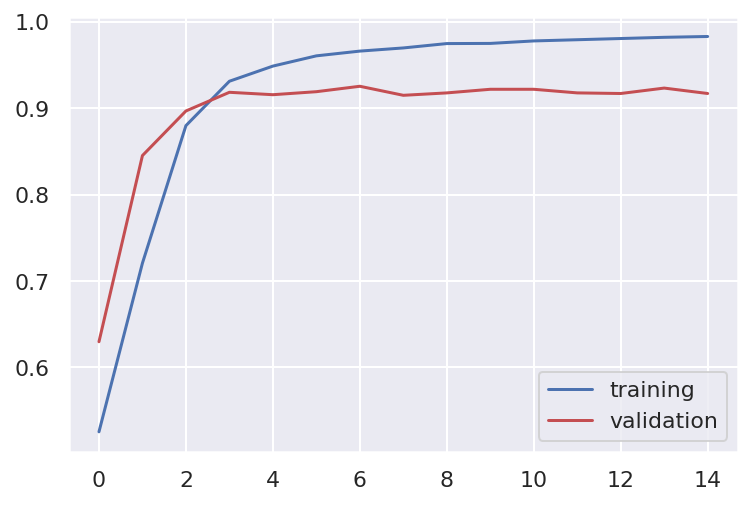

In [ ]:
# Just visualization of accuracy
plt.plot(train.history['accuracy'],c='b',label='training')
plt.plot(train.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# preparing the test data for evaluating the trained model
X_test=test_data['Cleaned Text'].astype(str)
Y_test=test_data["Emotion"].replace({'joy':0,'sadness':1,'anger':2,'fear':3,'love':4,'surprise':5})
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,maxlen=66,padding='post')
Y_test_f=to_categorical(Y_test)

In [ ]:
# just to find number of words in the longest sentence of the test data.
# should be runned before padding.
X_test_list = []
for i in X_test:
  X_test_list.append(len(i))
print(max(X_test_list))

66


In [ ]:
#evaluating the model
model.evaluate(X_test,Y_test_f)

45/45 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.9143


[0.295985609292984, 0.914345383644104]

In [ ]:
Y_pred=model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


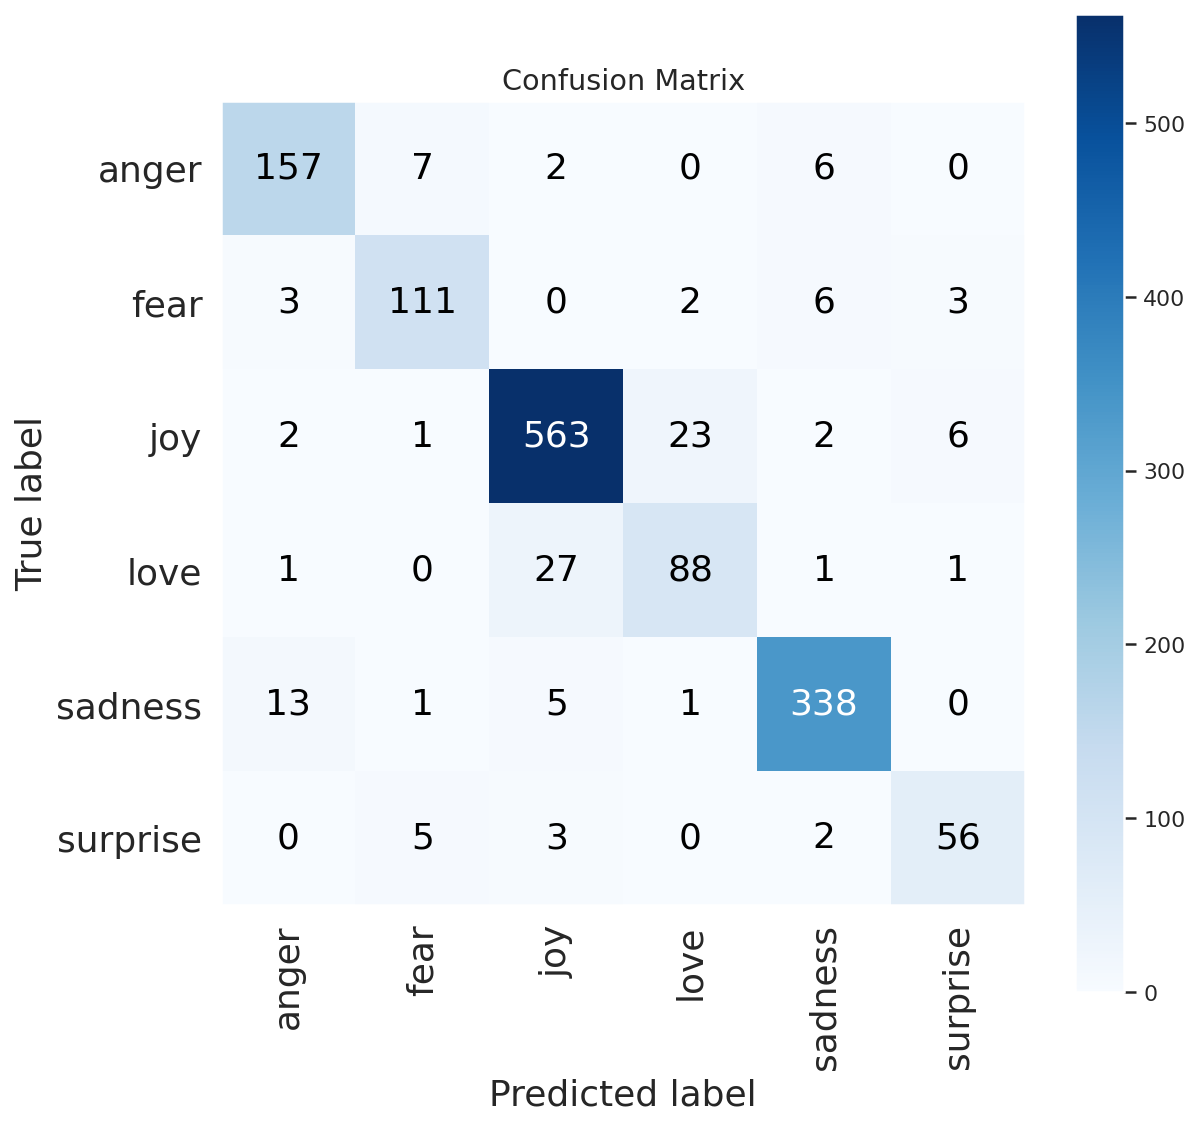

In [ ]:
# Confusion matrix
dictionary={0:'joy',1:'sadness',2:'anger',3:'fear',4:'love',5:'surprise'}
true=Y_test.replace({0:'joy',1:'sadness',2:'anger',3:'fear',4:'love',5:'surprise'})
predicted = []
for i in range(len(Y_pred)):
  current = Y_pred[i]
  emotion = dictionary.get(current)
  predicted.append(emotion)
plot_confusion_matrix(true,predicted,figsize=(9,9),x_tick_rotation=90,text_fontsize=18, )

In [ ]:
print(classification_report(true,predicted))

              precision    recall  f1-score   support

       anger       0.89      0.91      0.90       172
        fear       0.89      0.89      0.89       125
         joy       0.94      0.94      0.94       597
        love       0.77      0.75      0.76       118
     sadness       0.95      0.94      0.95       358
    surprise       0.85      0.85      0.85        66

    accuracy                           0.91      1436
   macro avg       0.88      0.88      0.88      1436
weighted avg       0.91      0.91      0.91      1436



In [ ]:
# helper function to convert prediction into the emotions
def get_key(value):
    dictionary={'joy':0,'sadness':1,'anger':2,'fear':3,'love':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key

In [ ]:
def make_prediction(sentence):
  sentence_lst=[]
  sentence_lst.append(sentence)
  sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
  sentence_padded=pad_sequences(sentence_seq,maxlen=66,padding='post')
  ans=get_key(model.predict_classes(sentence_padded))
  print("The predicted emotion is ",ans)

In [ ]:
make_prediction(str(input("Enter a sentence: ")))

Enter a sentence: i hate selfish people
The predicted emotion is  anger


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
